####This notebook walks through the GBT model of approach 2 : Model with feature importance
- to run this notebook please have the dataset "category_data" uploaded
- While uploading the above dataset make sure to set the schema as the following 
- Schema : _Date:timestamp, d:double, wm_yr_wk:double, weekday:string, month:double, year:double, Hobbies:double, Foods:double, HouseHold:double, event_name_1:string, event_type_1:string, event_name_2:string, event_type_2:string_

In [2]:
import random
random.seed(50)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from pyspark.sql.functions import udf, split, when, isnan, count, col, monotonically_increasing_id
from pyspark.sql.types import DateType, IntegerType, DoubleType, FloatType, StringType
from pyspark.sql import *
from pyspark.sql.window import Window
from pyspark.sql import functions as f
from sklearn.metrics import mean_squared_error
from pyspark.ml.feature import *
from pyspark.ml.feature import CountVectorizer, VectorIndexer, VectorAssembler,StringIndexer, OneHotEncoder, VectorSlicer
from pyspark.ml import Pipeline, feature
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.base import Estimator
from pyspark.ml.param import Params, Param, TypeConverters
from pyspark.ml.param.shared import HasOutputCol

#####User defined functions

In [4]:
#counting null values 
def check_null(dataset):
  null_count = dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns])
  return (null_count.show())

# Convert data in column to an array so as to use with Count Vectorizer
def convert_col_to_array(df,new_col,orig_col, split_char):
  return(df.withColumn(new_col,split(col(orig_col),split_char)))

# Count Vectorizer
def initialize_Count_Vectorizer(input_Col, output_Col):
  return(CountVectorizer(inputCol = input_Col, outputCol = output_Col))

#SMape error metric
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

#####Importing Data

In [6]:
#importing the data : 
df = spark.table("category_data")
display(df)

Date,d,wm_yr_wk,weekday,month,year,Hobbies,Foods,HouseHold,event_name_1,event_type_1,event_name_2,event_type_2
2011-01-29T00:00:00.000+0000,1.0,11101.0,Saturday,1.0,2011.0,3764.0,23178.0,5689.0,null,null,null,null
2011-01-30T00:00:00.000+0000,2.0,11101.0,Sunday,1.0,2011.0,3357.0,22758.0,5634.0,null,null,null,null
2011-01-31T00:00:00.000+0000,3.0,11101.0,Monday,1.0,2011.0,2682.0,17174.0,3927.0,null,null,null,null
2011-02-01T00:00:00.000+0000,4.0,11101.0,Tuesday,2.0,2011.0,2669.0,18878.0,3865.0,null,null,null,null
2011-02-02T00:00:00.000+0000,5.0,11101.0,Wednesday,2.0,2011.0,1814.0,14603.0,2729.0,null,null,null,null
2011-02-03T00:00:00.000+0000,6.0,11101.0,Thursday,2.0,2011.0,3220.0,22093.0,3898.0,null,null,null,null
2011-02-04T00:00:00.000+0000,7.0,11101.0,Friday,2.0,2011.0,2944.0,20490.0,4576.0,null,null,null,null
2011-02-05T00:00:00.000+0000,8.0,11102.0,Saturday,2.0,2011.0,3986.0,27751.0,6195.0,null,null,null,null
2011-02-06T00:00:00.000+0000,9.0,11102.0,Sunday,2.0,2011.0,2899.0,24862.0,4975.0,SuperBowl,Sporting,null,null
2011-02-07T00:00:00.000+0000,10.0,11102.0,Monday,2.0,2011.0,2615.0,18901.0,4056.0,null,null,null,null


##### Checking & replacing nulls in the given dataset
- The null values in columns event_name_1 and 2 and event_type_1 and 2 represents that there were no events hence they are replaced with string " No event"

In [9]:
print("Null values in the dataframe")
check_null(df)
print("                                                      ")
print("After replaing Null values in the dataframe")
#replacing null with string value 'No_event' in respective columns
df = df.na.fill({'event_name_1': 'No event','event_name_2': 'No event','event_type_1': 'No event','event_type_2': 'No event' })
check_null(df)

Null values in the dataframe
+----+---+--------+-------+-----+----+-------+-----+---------+------------+------------+------------+------------+
Date| d|wm_yr_wk|weekday|month|year|Hobbies|Foods|HouseHold|event_name_1|event_type_1|event_name_2|event_type_2|
+----+---+--------+-------+-----+----+-------+-----+---------+------------+------------+------------+------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 1783| 1783| 1937| 1937|
+----+---+--------+-------+-----+----+-------+-----+---------+------------+------------+------------+------------+

 
After replaing Null values in the dataframe
+----+---+--------+-------+-----+----+-------+-----+---------+------------+------------+------------+------------+
Date| d|wm_yr_wk|weekday|month|year|Hobbies|Foods|HouseHold|event_name_1|event_type_1|event_name_2|event_type_2|
+----+---+--------+-------+-----+----+-------+-----+---------+------------+------------+------------+------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----+---+--------+-------+-----+----+-------+-----+---------+------------+------------+------------+------------+

#####Feature Generation
- "no_of_events" - This column gives the total number of events for each day by summing the columns event_name_1 and 2
- More features are generated below

In [11]:
def count_events(c1, c2):
  if c1 != "No event" and c2 != "No event":
    return 2
  elif c1 == "No event" and c2 != "No event":
    return 1
  elif c1 != "No event" and c2 == "No event":
    return 1
  else:
    return 0

combineUDF = udf(count_events)
expr = [c for c in df] + [combineUDF(col("event_name_1"), col("event_name_2")).alias("no_of_events").cast(DoubleType())]
df = df.select(*expr)

In [12]:
display(df)

Date,d,wm_yr_wk,weekday,month,year,Hobbies,Foods,HouseHold,event_name_1,event_type_1,event_name_2,event_type_2,no_of_events
2011-01-29T00:00:00.000+0000,1.0,11101.0,Saturday,1.0,2011.0,3764.0,23178.0,5689.0,No event,No event,No event,No event,0.0
2011-01-30T00:00:00.000+0000,2.0,11101.0,Sunday,1.0,2011.0,3357.0,22758.0,5634.0,No event,No event,No event,No event,0.0
2011-01-31T00:00:00.000+0000,3.0,11101.0,Monday,1.0,2011.0,2682.0,17174.0,3927.0,No event,No event,No event,No event,0.0
2011-02-01T00:00:00.000+0000,4.0,11101.0,Tuesday,2.0,2011.0,2669.0,18878.0,3865.0,No event,No event,No event,No event,0.0
2011-02-02T00:00:00.000+0000,5.0,11101.0,Wednesday,2.0,2011.0,1814.0,14603.0,2729.0,No event,No event,No event,No event,0.0
2011-02-03T00:00:00.000+0000,6.0,11101.0,Thursday,2.0,2011.0,3220.0,22093.0,3898.0,No event,No event,No event,No event,0.0
2011-02-04T00:00:00.000+0000,7.0,11101.0,Friday,2.0,2011.0,2944.0,20490.0,4576.0,No event,No event,No event,No event,0.0
2011-02-05T00:00:00.000+0000,8.0,11102.0,Saturday,2.0,2011.0,3986.0,27751.0,6195.0,No event,No event,No event,No event,0.0
2011-02-06T00:00:00.000+0000,9.0,11102.0,Sunday,2.0,2011.0,2899.0,24862.0,4975.0,SuperBowl,Sporting,No event,No event,1.0
2011-02-07T00:00:00.000+0000,10.0,11102.0,Monday,2.0,2011.0,2615.0,18901.0,4056.0,No event,No event,No event,No event,0.0


In [13]:
# dropping columns we won't be considering for model development
cat_df = df.drop("event_name_1","event_name_2")

#####One hot encoding of categorical columns
- The columns weekday, month, year, event_type_1 and event_type_2 are one hot encoded

In [15]:
#One Hot Encoding of categorical columns

OHE_list= ['weekday','month','year','event_type_1','event_type_2']

# Generate OHE for elements in the list above
for element in OHE_list:
  print(element)
  
#Convert String to Array so that OHE can run (requires an array as an input)
  cat_df = convert_col_to_array(cat_df, element + '_array', element,' ')
  
#Initialize Count vectorizer
  elementVectorizer = initialize_Count_Vectorizer(element + '_array',element + '_OHE')
  
#Fit a vectorizer model
  elementVectorizer_model = elementVectorizer.fit(cat_df)
  
#Transform Data
  cat_df = elementVectorizer_model.transform(cat_df)
  
#Specify Extraneous Cols to drop 
  columns_to_drop = [element, element + '_array']
  
#Drop Extraneous Cols listed above
  cat_df = cat_df.drop(*columns_to_drop)

weekday
month
year
event_type_1
event_type_2

In [16]:
#dataset after OHE
display(cat_df)

Date,d,wm_yr_wk,Hobbies,Foods,HouseHold,no_of_events,weekday_OHE,month_OHE,year_OHE,event_type_1_OHE,event_type_2_OHE
2011-01-29T00:00:00.000+0000,1.0,11101.0,3764.0,23178.0,5689.0,0.0,"List(0, 7, List(1), List(1.0))","List(0, 12, List(4), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-01-30T00:00:00.000+0000,2.0,11101.0,3357.0,22758.0,5634.0,0.0,"List(0, 7, List(0), List(1.0))","List(0, 12, List(4), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-01-31T00:00:00.000+0000,3.0,11101.0,2682.0,17174.0,3927.0,0.0,"List(0, 7, List(2), List(1.0))","List(0, 12, List(4), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-02-01T00:00:00.000+0000,4.0,11101.0,2669.0,18878.0,3865.0,0.0,"List(0, 7, List(6), List(1.0))","List(0, 12, List(3), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-02-02T00:00:00.000+0000,5.0,11101.0,1814.0,14603.0,2729.0,0.0,"List(0, 7, List(3), List(1.0))","List(0, 12, List(3), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-02-03T00:00:00.000+0000,6.0,11101.0,3220.0,22093.0,3898.0,0.0,"List(0, 7, List(5), List(1.0))","List(0, 12, List(3), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-02-04T00:00:00.000+0000,7.0,11101.0,2944.0,20490.0,4576.0,0.0,"List(0, 7, List(4), List(1.0))","List(0, 12, List(3), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-02-05T00:00:00.000+0000,8.0,11102.0,3986.0,27751.0,6195.0,0.0,"List(0, 7, List(1), List(1.0))","List(0, 12, List(3), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-02-06T00:00:00.000+0000,9.0,11102.0,2899.0,24862.0,4975.0,1.0,"List(0, 7, List(0), List(1.0))","List(0, 12, List(3), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(5), List(1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"
2011-02-07T00:00:00.000+0000,10.0,11102.0,2615.0,18901.0,4056.0,0.0,"List(0, 7, List(2), List(1.0))","List(0, 12, List(3), List(1.0))","List(0, 6, List(4), List(1.0))","List(0, 6, List(0, 1), List(1.0, 1.0))","List(0, 4, List(0, 1), List(1.0, 1.0))"


#####Defining Time Horizons
The datasets are prepared and subsetted for the over three time horizon for each of the three catergories
1. Day
2. Week
3. Month

In [18]:
#function for creating lags in the dataset

def time_horizon(input_df, lag):
  window = Window.orderBy("d")
  output_df_name = input_df.withColumn("lag_Hobbies",f.lag(col("Hobbies"),lag).over(window)).withColumn("lag_Foods",f.lag(col("Foods"),lag).over(window)).withColumn("lag_HH",f.lag(col("HouseHold"),lag).over(window)).drop("Hobbies","Foods","HouseHold")
  return(output_df_name)

day_df = time_horizon(cat_df,-1)
week_df = time_horizon(cat_df,-7)
month_df = time_horizon(cat_df,-28)

In [19]:
#Subsetting dataframes for day, week, month over all categories
def sub_data(dataset,category):
  list1 = ['lag_Foods', 'lag_HH']
  list2 = ['lag_Hobbies', 'lag_HH']
  list3 = ['lag_Hobbies', 'lag_Foods']
  Hobbies_x = dataset.drop(*list1)
  Foods_x = dataset.drop(*list2)
  HH_x = dataset.drop(*list3)
  if category == "Hobbies":
     return (Hobbies_x)
  elif category == "Foods":
     return (Foods_x)
  elif category == "HouseHold":
     return (HH_x)
  else:
    return(print("Enter either Hobbies, Foods or HouseHold"))

Hobbies_day = sub_data(day_df,"Hobbies")
Foods_day = sub_data(day_df,"Foods")
HH_day = sub_data(day_df,"HouseHold")

Hobbies_week = sub_data(week_df,"Hobbies")
Foods_week = sub_data(week_df,"Foods")
HH_week = sub_data(week_df,"HouseHold")

Hobbies_month = sub_data(month_df,"Hobbies")
Foods_month = sub_data(month_df,"Foods")
HH_month = sub_data(month_df,"HouseHold")

#####Feature Generation
The following 10 features are generated representing the sales quantity in past for different time range,
>>1. __Pre_d1__ : the sales quantity one day before the target
2.  __Pre_d2__ : the sales quantity two days before the target
3.  __Pre_d3__ : the sales quantity three days before the target
4.  __Pre_d4__ : the sales quantity four days before the target
5.  __Pre_d5__ : the sales quantity five days before the target
6.  __Pre_d6__ : the sales quantity six days before the target
7.  __Pre_d7__ : the sales quantity seven days before the target
8.  __Pre_d10__ : the sales quantity ten days before the target
9.  __Pre_d14__ : the sales quantity fourteen days before the target
10.  __Pre_d28__ : the sales quantity twenty eight days before the target

All of these generated features along with rest of features already available will be passed through a feature selector and the model will be implemented with the auto  selected features

In [21]:
def generate_feat(df1,df2,column):
    window = Window.orderBy("d")
    x = df1.withColumn("Pre_d1",f.lag(col(column),1).over(window)).withColumn("Pre_d2",f.lag(col(column),2).over(window)).withColumn("Pre_d3",f.lag(col(column),3).over(window)).withColumn("Pre_d4",f.lag(col(column),4).over(window)).withColumn("Pre_d5",f.lag(col(column),5).over(window)).withColumn("Pre_d6",f.lag(col(column),6).over(window)).withColumn("Pre_d7",f.lag(col(column),7).over(window)).withColumn("Pre_d10",f.lag(col(column),10).over(window)).withColumn("Pre_d14",f.lag(col(column),14).over(window)).withColumn("Pre_d28",f.lag(col(column),28).over(window))
    x_sub = x.select("d","Pre_d1","Pre_d2","Pre_d3","Pre_d4","Pre_d5","Pre_d6","Pre_d7","Pre_d10","Pre_d14","Pre_d28")
    df2 = df2.join(x_sub, x_sub.d == df2.d).drop("d")
    return(df2)
 
Hob_day = generate_feat(cat_df,Hobbies_day,"Hobbies").dropna()
F_day   = generate_feat(cat_df,Foods_day,"Foods").dropna()
HH_day  = generate_feat(cat_df,HH_day,"HouseHold").dropna()

Hob_week = generate_feat(cat_df,Hobbies_week,"Hobbies").dropna()
F_week   = generate_feat(cat_df,Foods_week,"Foods").dropna()
HH_week  = generate_feat(cat_df,HH_week,"HouseHold").dropna()

Hob_month = generate_feat(cat_df,Hobbies_month,"Hobbies").dropna()
F_month = generate_feat(cat_df,Foods_month,"Foods").dropna()
HH_month = generate_feat(cat_df,HH_month,"HouseHold").dropna()

##### GBT model implemetation along with Feature Importance
- The following blocks of code uses feature importance and selects the top 10 features and passes it through the GBT model

In [23]:
#creating list of variables involving datasets, target column names, feature column names to pass and loop through the model 
Data_sets = [Hob_day, Hob_week, Hob_month, F_day, F_week, F_month, HH_day, HH_week, HH_month]
Data_set_names = ['Hobbies_day', 'Hobbies_week', 'Hobbies_month', 'Foods_day', 'Foods_week', 'Foods_month', 'Household_day', 'Household_week', 'Household_month']
Lags = ['lag_Hobbies','lag_Hobbies','lag_Hobbies','lag_Foods','lag_Foods','lag_Foods','lag_HH','lag_HH','lag_HH']
Quantities = ['Hobbies_quantity','Hobbies_quantity','Hobbies_quantity','Foods_quantity','Foods_quantity','Foods_quantity','HH_quantity','HH_quantity','HH_quantity']
GBT_featureimportance_DataFrames = ['GBT_Hobbies_features_day', 'GBT_Hobbies_features_week', 'GBT_Hobbies_features_month', 'GBT_Foods_features_day', 'GBT_Foods_features_week', 'GBT_Foods_features_month', 'GBT_HH_features_day', 'GBT_HH_features_week', 'GBT_HH_features_month']
Predictions_GBT = ['Predictions_GBT_Hobbies_day','Predictions_GBT_Hobbies_week','Predictions_GBT_Hobbies_month', 'Predictions_GBT_Foods_day', 'Predictions_GBT_Foods_week','Predictions_GBT_Foods_month','Predictions_GBT_HH_day', 'Predictions_GBT_HH_week', 'Predictions_GBT_HH_month']


In [24]:
#user defined function to select important features. this takes in feature importance from a model and map it to column names
def ExtractFeatureImp(featureImp, dataset, featuresCol):
  
 
  list_extract = []
  for i in dataset.schema[featuresCol].metadata['ml_attr']['attrs']:
    list_extract = list_extract + dataset.schema[featuresCol].metadata['ml_attr']['attrs'][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return (varlist.sort_values('score', ascending = False))

##### GBT model results with Hyperparameter tuning and Feature Importance
- The following blocks of code performs Grid search to select the best hyperparameters resulting in the least SMape score 
- the results displayed below are the Hyperparameters and SMape score for each of our target specific datasets

In [26]:
from pandas import DataFrame
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn import datasets, ensemble
for data_set in range(9):
  
    # Specify Input Columns that will become features in our final models
  feature_column_df = Data_sets[data_set].drop('Date')
  featuresCols = feature_column_df.columns
  featuresCols.remove(Lags[data_set])

  #Build Features using the feature assemblerfeature_column_df
  feature_assembler = VectorAssembler(inputCols = featuresCols, outputCol = "features")
  output = feature_assembler.transform(feature_column_df) # Transform dataframe into features
  Data_model = output.select("features", Lags[data_set]) # Generate final output two cols: one with features and the other with the  target 

  
  Data_model = Data_model.select(col("features"),col(Lags[data_set]).alias(Quantities[data_set]))

  #Build Feature Indexer:
  feature_Indexer = VectorIndexer(inputCol = 'features', outputCol = 'indexedFeatures',maxCategories = 12).fit(Data_model)


  Data_model = Data_model.select("*").withColumn("id", monotonically_increasing_id())
  
  
  Data = Data_model.drop('id')
  X = np.array(Data.select('features',Quantities[data_set]).collect())
  splits = TimeSeriesSplit(n_splits=3)
  maxDepth = (2,5)
  maxIter = (10,20)
  GBT_featureimportance_list = []
  for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_df_pyspark = Data_model.where(col("id").between(0, len(train))).drop('id')
    test_df_pyspark = Data_model.where(col("id").between(len(train)+1, len(train)+len(test))).drop('id')
    for i in maxDepth:
      for j in maxIter:
       
        # Build Gradient Boosting Regressor
        GBT = GBTRegressor(labelCol=Quantities[data_set],maxDepth = i, maxIter = j)

        #Build pipeline with feature indexer and regressor
        pipeline = Pipeline(stages = [feature_Indexer, GBT])

        #Train Model while running indexer
        model = pipeline.fit(train_df_pyspark)

        #Make Predictions on test Data
        predictions = model.transform(test_df_pyspark)

        varlist = ExtractFeatureImp(model.stages[-1].featureImportances, predictions, "features")
        varidx = [x for x in varlist['idx'][0:10]]
        slicer = VectorSlicer(inputCol = 'features', outputCol = 'new features', indices = varidx)
        new_df = slicer.transform(predictions)
        new_df = new_df.drop('rawPrediction', 'probability', 'prediction') 

        regressor_2 = GBTRegressor(featuresCol = 'new features', labelCol = Quantities[data_set],maxDepth = i, maxIter = j)

        mod2 = regressor_2.fit(new_df)
        new_predictions = mod2.transform(new_df)
        # Select (prediction, true label) and compute test error
        e = RegressionEvaluator(metricName="r2", labelCol=regressor_2.getLabelCol(), predictionCol=regressor_2.getPredictionCol())
        #Evaluate Predictions using aforementioned Evaluator
        r2= e.evaluate(new_predictions)
        A = np.array(new_predictions.select(Quantities[data_set]).collect())
        F = np.array(new_predictions.select('prediction').collect())
        s = smape(A,F)
        f = (i,j,r2,s)
        GBT_featureimportance_list.append(f)
  GBT_featureimportance_DataFrames[data_set] = DataFrame(GBT_featureimportance_list,columns=['maxDepth','maxIter','r2','SMape'])
  final_predications = new_predictions.select(Quantities[data_set],'prediction')
  Predictions_GBT[data_set] = final_predications.toPandas()
 # Predictions_GBT[data_set].index = range(1435, 1912, 1)
  
  BB = GBT_featureimportance_DataFrames[data_set]['SMape'].tolist()
  required_index = GBT_featureimportance_DataFrames[data_set].loc[GBT_featureimportance_DataFrames[data_set]['SMape']==min(BB)].index
  Depth = GBT_featureimportance_DataFrames[data_set].iloc[required_index]['maxDepth'].to_string(index = False)
  Iter = GBT_featureimportance_DataFrames[data_set].iloc[required_index]['maxIter'].to_string(index = False)
  r2 = GBT_featureimportance_DataFrames[data_set].iloc[required_index]['r2'].to_string(index = False)
  SMape = GBT_featureimportance_DataFrames[data_set].iloc[required_index]['SMape'].to_string(index = False)
  print("The best hyperparameters of GBT model for {} are MaxDepth:{} and MaxIter:{} with resultant r2:{} and Smape:{} ".format((Data_set_names[data_set]),Depth, Iter, r2, SMape))

The best hyperparameters of GBT model for Hobbies_day are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.93333 and Smape: 3.342158 
The best hyperparameters of GBT model for Hobbies_week are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.945638 and Smape: 3.17565 
The best hyperparameters of GBT model for Hobbies_month are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.931657 and Smape: 3.500692 
The best hyperparameters of GBT model for Foods_day are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.944741 and Smape: 3.52883 
The best hyperparameters of GBT model for Foods_week are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.936006 and Smape: 3.627239 
The best hyperparameters of GBT model for Foods_month are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.960104 and Smape: 3.226957 
The best hyperparameters of GBT model for Household_day are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.958461 and Smape: 3.343777 
The best hyperparameters of GBT model for Household_week are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.956755 and Smape: 3.40908 
The best hyperparameters of GBT model for Household_month are MaxDepth: 5 and MaxIter: 20 with resultant r2: 0.95954 and Smape: 3.327092

##### Plotting Actual Vs Prediction results
- The plots below represent the prediction vs actual values of all target specific datasets for 1 day horizon

In [28]:
#forming a dataframe with the results of 1 day horizon
Hob_plot = Predictions_GBT[0]
F_plot = Predictions_GBT[3]
HH_plot = Predictions_GBT[6]
Hob_plot['d'] = np.arange(len(Hob_plot))
F_plot['d'] = np.arange(len(F_plot))
HH_plot['d'] = np.arange(len(HH_plot))
merge_df = Hob_plot.merge(F_plot,on='d').merge(HH_plot,on='d')
pred_df_1day = merge_df.drop(columns=['d'])
Predictions_GBT = pred_df_1day

--------------------------------------------------------------------------- 
 KeyError Traceback (most recent call last)
 /databricks/python/lib/python3.7/site-packages/pandas/core/indexes/base.py in get_loc (self, key, method, tolerance) 
 2645 try : 
 -> 2646 return self . _engine . get_loc ( key ) 
 2647 except KeyError : 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 KeyError : 0

During handling of the above exception, another exception occurred:

 KeyError Traceback (most recent call last)
 <command-501782325992387> in <module> 
 1 #forming a dataframe with the results of 1 day horizon 
 ----> 2 Hob_plot = Predictions_GBT [ 0 ] 
 3 F_plot = Predictions_GBT [ 3 ] 
 4 HH_plot = Predictions_GBT [ 6 ] 
 5 Hob_plot [ 'd' ] = np . arange ( len ( Hob_plot ) ) 

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in __getitem__ (self, key) 
 2798 if self . columns . nlevels > 1 : 
 2799 return self . _getitem_multilevel ( key ) 
 -> 2800 indexer = self . columns . get_loc ( key ) 
 2801 if is_integer ( indexer ) : 
 2802 indexer = [ indexer ] 

 /databricks/python/lib/python3.7/site-packages/pandas/core/indexes/base.py in get_loc (self, key, method, tolerance) 
 2646 return self . _engine . get_loc ( key ) 
 2647 except KeyError : 
 -> 2648 return self . _engine . get_loc ( self . _maybe_cast_indexer ( key ) ) 
 2649 indexer = self . get_indexer ( [ key ] , method = method , tolerance = tolerance ) 
 2650 if indexer . ndim > 1 or indexer . size > 1 : 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 KeyError : 0

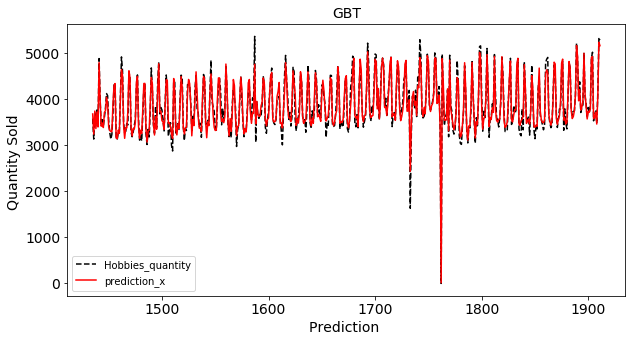

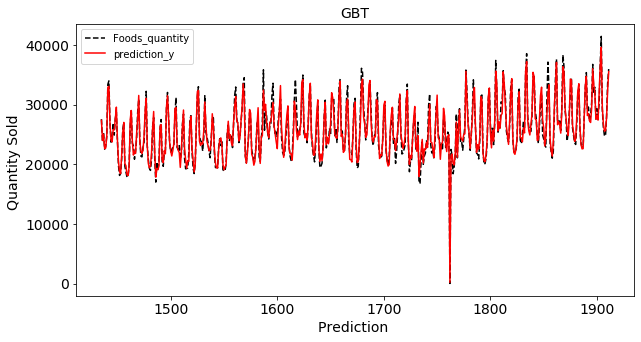

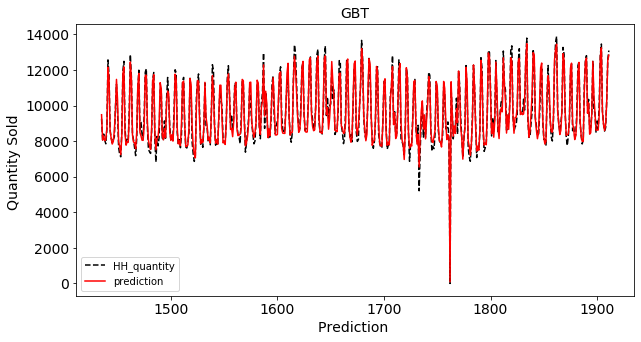

In [29]:
Index_list = [0,1,2]

# Lists that Index_list indexes into:
Horizons = ['Hobbies on Day Horizon', 'Foods on Day Horizon', 'House Holds on Day Horizon']
Column_names =['Hobbies_quantity','Foods_quantity','HH_quantity'] # Column Names for Target Variables
Column_pred = ['prediction_x', 'prediction_y', 'prediction'] # Column Names for Predictions

f_size = 14 # Font Size

# Reindexing Dataframes

Predictions_GBT.index = range(1463, 1940, 1)

for i in Index_list:
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10 ,5));
  axes.set_title("GBT", fontsize = f_size)
  axes.set_xlabel('Prediction ', fontsize = f_size)
  axes.set_ylabel('Quantity Sold ', fontsize = f_size)
  
  print('--------------------------------Plotting prediction for dataset{}---------------------------------'.format((Horizons[i])))
 
  Predictions_GBT[[Column_names[i], Column_pred[i]]].plot(ax=axes, color=['Black', 'Red'],  style= ['--', '-'], fontsize = f_size)
  
  plt.show() 
